In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import time
import random
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing

#import statsmodels as sm
#import statsmodels.api as smt
#from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
import tensorflow as tf

np.random.seed(1) 
tf.random.set_seed(1) 
random.seed(1)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16,5

import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import and Preprocess 

In [ ]:
# Mount to drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Change directory
% cd '/content/drive/'

/content/drive


In [ ]:
# Import data

#dateparse = lambda dates: pd.datetime.strptime(dates, '%b-%y')
data = pd.read_csv('/content/drive/My Drive/unemployment-rate-1948-2021.csv',
                   parse_dates=['yearmonth'], 
                   index_col='yearmonth')

ts_all = data['unemployment rate']

In [ ]:
ts_all.head()

yearmonth
1948-01-01    3.4
1948-02-01    3.8
1948-03-01    4.0
1948-04-01    3.9
1948-05-01    3.5
Name: unemployment rate, dtype: float64

In [ ]:
# Check how many value in time series

len(ts_all)

882

In [ ]:
# Descriptive stats for unemployment rate

ts_all.describe()

count    882.000000
mean       5.768594
std        1.701312
min        2.500000
25%        4.500000
50%        5.600000
75%        6.800000
max       14.800000
Name: unemployment rate, dtype: float64

In [ ]:
# Check is there any missing value in time series

if data.isnull().values.any():
    print("Having missing values")
else:
   print("No missing values")

No missing values


Text(0, 0.5, 'Unemployment Rate (%)')

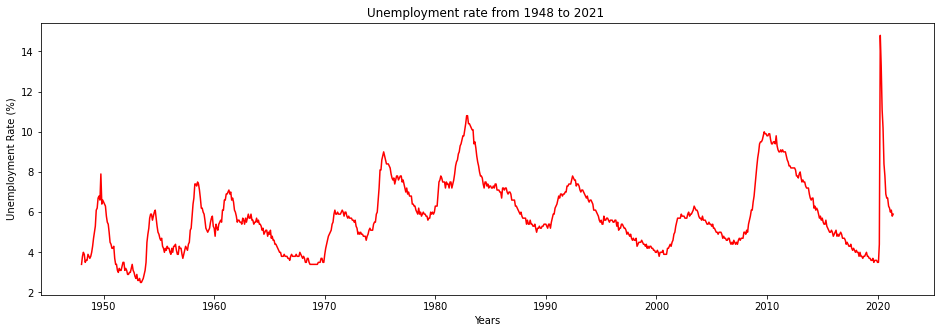

In [ ]:
plt.figure(figsize=(16, 5)) 
plt.plot(ts_all,'r-') 
plt.title('Unemployment rate from 1948 to 2021 ') 
plt.xlabel('Years') 
plt.ylabel('Unemployment Rate (%)')

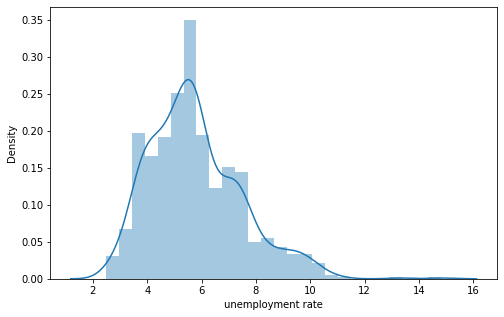

In [ ]:
# Check data distribution

plt.figure(figsize=(8, 5)) 

sns.distplot(ts_all)

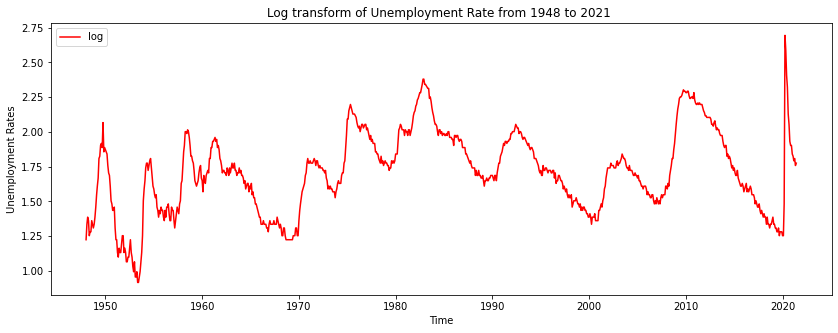

In [ ]:
# Check stationary of time series after using log transformation

ts_log= np.log(ts_all)
plt.figure(figsize=(14, 5)) 
plt.plot(ts_log, color='red',label='log')
plt.title('Log transform of Unemployment Rate from 1948 to 2021 ') 
plt.xlabel('Time')
plt.ylabel('Unemployment Rates')
plt.legend()

In [ ]:
# ADF test
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Perform Augmented Dickey-Fuller test:
    print('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(ts_log)
print("--------------")
test_stationarity(ts_all)

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -3.473758
p-value                          0.008687
#Lags Used                       1.000000
Number of Observations Used    880.000000
Critical Value (1%)             -3.437803
Critical Value (5%)             -2.864830
Critical Value (10%)            -2.568522
dtype: float64
--------------
Results of Augmented Dickey-Fuller Test:
Test Statistic                  -4.007829
p-value                          0.001370
#Lags Used                       1.000000
Number of Observations Used    880.000000
Critical Value (1%)             -3.437803
Critical Value (5%)             -2.864830
Critical Value (10%)            -2.568522
dtype: float64


## Split Train-Test Dataset

In [ ]:
# Use data from 1948 to 2014 as train data
# Use data from 2015 to 2021 as test data

size_test = 78
size_train = len(ts_all) - size_test

ts_train = ts_all[ : size_train]
ts_test = ts_all[ -size_test:] # Last 78 data

In [ ]:
# Use data from 1948 to 2020 as train data
# Use data from 2021 as test data

size_test1 = 6
size_train1 = len(ts_all) - size_test1

ts_train1 = ts_all[ : size_train1]
ts_test1 = ts_all[ -size_test1:] # Last 6 data

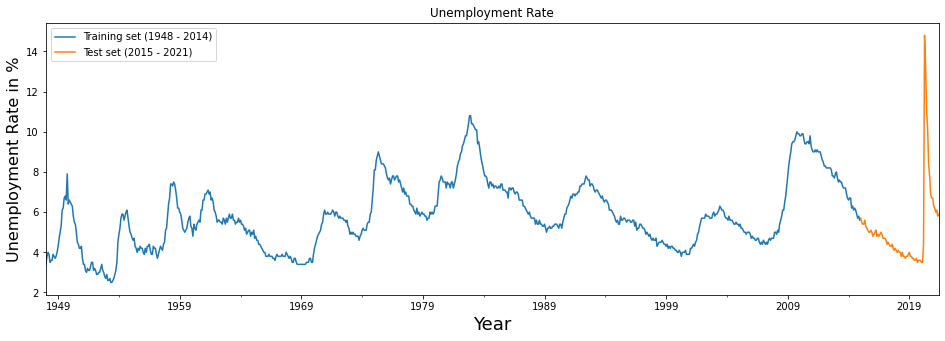

In [ ]:
ts_train.plot(figsize=(16,5),legend=True)
ts_test.plot(figsize=(16,5),legend=True)
plt.legend(['Training set (1948 - 2014)','Test set (2015 - 2021)'])
plt.title('Unemployment Rate')
plt.xlabel('Year', fontsize=18)
plt.ylabel('Unemployment Rate in %', fontsize=16)
plt.show()

### Define MSE function for calculating MSE value

In [ ]:
def mse(x, y):
    return np.mean(np.power(x - y,2))

### Apply decomposition function

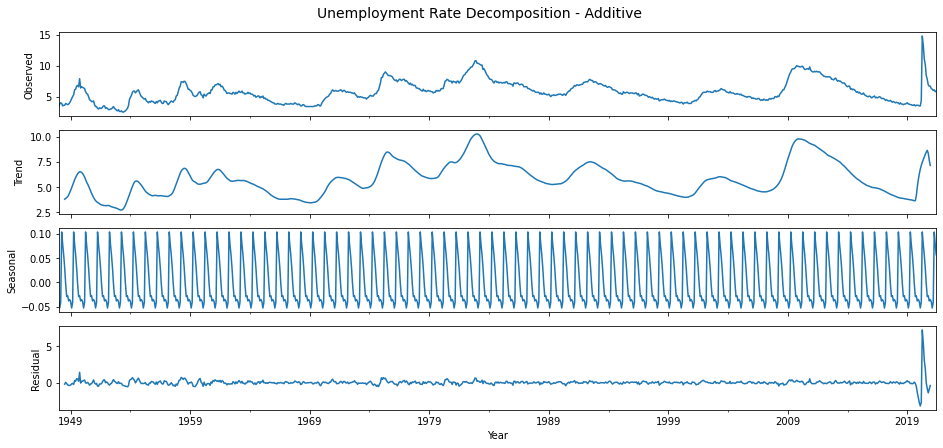

In [ ]:
# Use decomposition function with addtitive method to see trend and seasonality pattern

decompose_result = seasonal_decompose(ts_all, model='additive')

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True)
 
decompose_result.observed.plot(figsize=(13,6), ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
decompose_result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
decompose_result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
decompose_result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')

plt.suptitle('Unemployment Rate Decomposition - Additive', y=1.03, fontsize=14)
plt.xlabel('Year')
plt.tight_layout()
plt.show()

In [ ]:
#build and train the model on the training data
model = ExponentialSmoothing(ts_train, seasonal_periods=12, trend='add', seasonal='add', damped=True)
fitted = model.fit(optimized=True, use_brute=True)

In [ ]:
#build and train the model on the training data
model1 = ExponentialSmoothing(ts_train1, seasonal_periods=12, trend='add', seasonal='add', damped=True)
fitted1 = model1.fit(optimized=True, use_brute=True)

In [ ]:
#print out the training summary
print(fitted.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  804
Model:             ExponentialSmoothing   SSE                             31.450
Optimized:                         True   AIC                          -2571.934
Trend:                         Additive   BIC                          -2492.211
Seasonal:                      Additive   AICC                         -2570.965
Seasonal Periods:                    12   Date:                 Wed, 21 Jul 2021
Box-Cox:                          False   Time:                         00:37:17
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.7250367                alpha                 True
smoothing_slope          

In [ ]:
#print out the training summary
print(fitted1.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  876
Model:             ExponentialSmoothing   SSE                            163.014
Optimized:                         True   AIC                          -1439.019
Trend:                         Additive   BIC                          -1357.838
Seasonal:                      Additive   AICC                         -1438.131
Seasonal Periods:                    12   Date:                 Wed, 21 Jul 2021
Box-Cox:                          False   Time:                         14:59:47
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8947368                alpha                 True
smoothing_slope          

In [ ]:
#create an out of sample forcast for the next 12 steps beyond the final data point in the training data set
unrate_forecast = fitted.forecast(steps=78)

In [ ]:
#create an out of sample forcast for the next 6 steps beyond the final data point in the training data set
unrate_forecast1 = fitted1.forecast(steps=6)

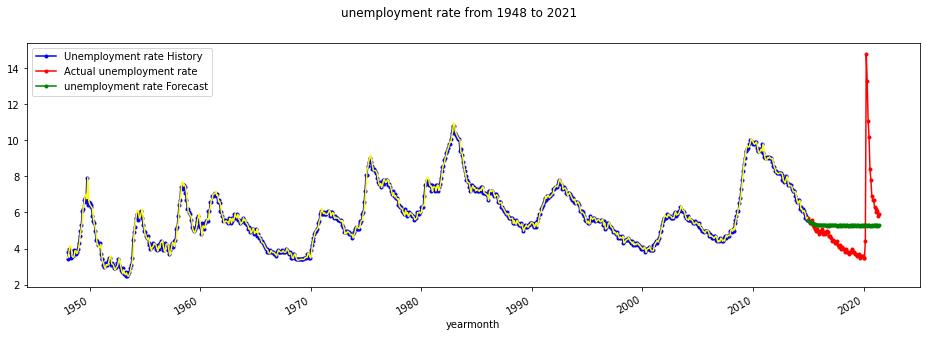

In [ ]:
#plot the training data, the test data and the forecast on the same plot
fig = plt.figure(figsize=(16, 5))
fig.suptitle('unemployment rate from 1948 to 2021')
past, = plt.plot(ts_train.index, ts_train, 'b.-', label='Unemployment rate History')
future, = plt.plot(ts_test.index, ts_test, 'r.-', label='Actual unemployment rate')
predicted_future, = plt.plot(ts_test.index, unrate_forecast, 'g.-', label='unemployment rate Forecast')
predicted_past, = fitted.fittedvalues.plot(color='yellow', legend=True)
plt.legend(handles=[past, future, predicted_future])
plt.show()

TypeError: ignored

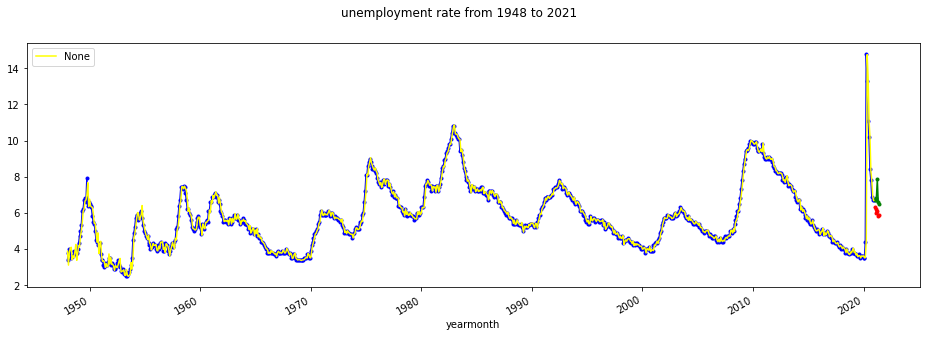

In [ ]:
#plot the training data, the test data and the forecast on the same plot
fig = plt.figure(figsize=(16, 5))
fig.suptitle('unemployment rate from 1948 to 2021')
past, = plt.plot(ts_train1.index, ts_train1, 'b.-', label='Unemployment rate History')
future, = plt.plot(ts_test1.index, ts_test1, 'r.-', label='Actual unemployment rate')
predicted_future, = plt.plot(ts_test1.index, unrate_forecast1, 'g.-', label='unemployment rate Forecast')
predicted_past, = fitted1.fittedvalues.plot(color='yellow', legend=True)
plt.legend(handles=[past, future, predicted_future])
plt.show()